In [22]:
import os
import re
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [23]:
home_dir = '/kaggle/input/utkface-new/UTKFace'

# Modelo a ser utilizado
cnn_modelo = "MobileNetV2"  # Modelos disponíveis: InceptionV3, MobileNetV2, ResNet50, EfficientNetB0, cnn_tcc_will

EPOCHS = 50  # Limitado para não ultrapassar tempo do Kaggle

# Set the data generators
BATCH_SIZE=64

print(f"Versão do TensorFlow: {tf.__version__}")
print(f"Modelo Selecionado: {cnn_modelo}")

Versão do TensorFlow: 2.17.1
Modelo Selecionado: InceptionV3


In [24]:
def load_dataset(directory):
    paths = []
    ages = []
    ignored_files = 0
    ignored_examples = []  # Lista para armazenar arquivos ignorados
    
    for filename in tqdm(sorted(os.listdir(directory))):  # Ordenar para consistência
        try:
            match = re.match(r'^(\d+)', filename)  # Captura somente a idade
            if not match:
                raise ValueError(f"Formato inválido: {filename}")
                
            age = int(match.group(1))
            if not (0 < age < 100):  # Filtrar idades inválidas
                raise ValueError(f"Idade fora do intervalo: {filename}")
                
            paths.append(os.path.join(directory, filename))
            ages.append(age)
        except (ValueError, IndexError, OSError) as e:
            ignored_files += 1
            ignored_examples.append(filename)

    print(f"Arquivos ignorados em {directory}: {ignored_files}")
    if ignored_files > 0:
        print(f"Exemplos ignorados: {ignored_examples[:5]}")  # Mostrar até 5 exemplos

    return pd.DataFrame({'path': paths, 'age': ages})


In [25]:
# Carregar ambos datasets
df = load_dataset(home_dir)

# Verificar se os datasets carregaram corretamente
print(f"UTKFace dataset: {df.shape[0]} imagens carregadas")


# Exibir algumas amostras para checagem
print("UTKFace dataset (amostras):")
print(df.head())

  0%|          | 0/23708 [00:00<?, ?it/s]

Arquivos ignorados em /kaggle/input/utkface-new/UTKFace: 32
Exemplos ignorados: ['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg']
UTKFace dataset: 23676 imagens carregadas
UTKFace dataset (amostras):
                                                path  age
0  /kaggle/input/utkface-new/UTKFace/10_0_0_20161...   10
1  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
2  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
3  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
4  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10


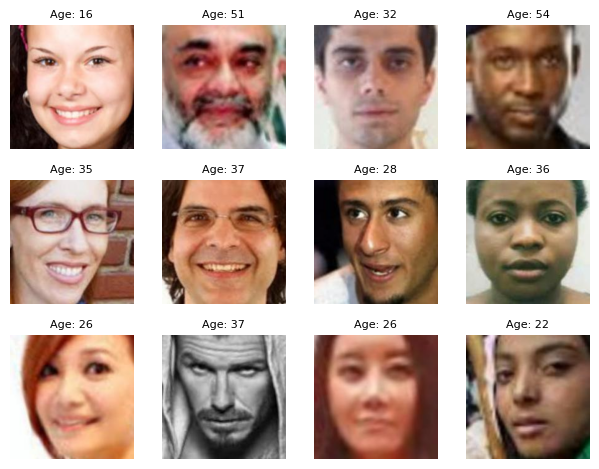

In [26]:
# Display 12 random images
data_sample = df.sample(12).reset_index(drop=True)
       # Display 12 random images
data_sample = df.sample(12).reset_index(drop=True)
       
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age}', fontsize=8)
    plt.axis('off')
plt.tight_layout()

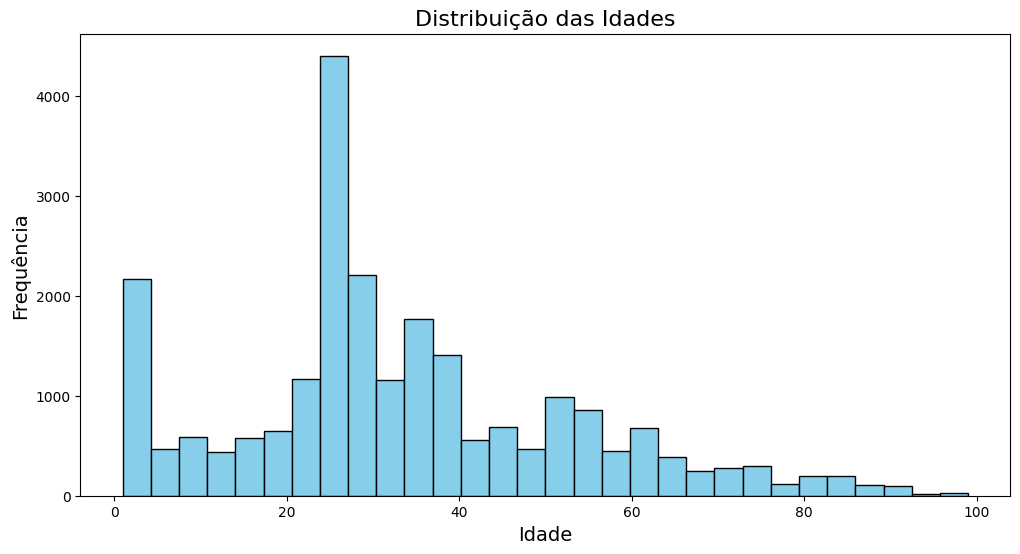

In [27]:
df['age'] = df['age'].replace([np.inf, -np.inf], np.nan)

# Configura o tamanho da figura
plt.figure(figsize=(12, 6))

# Cria o histograma
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='black')

# Adiciona título e rótulos aos eixos
plt.title('Distribuição das Idades', fontsize=16)
plt.xlabel('Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Exibe o gráfico
plt.show()

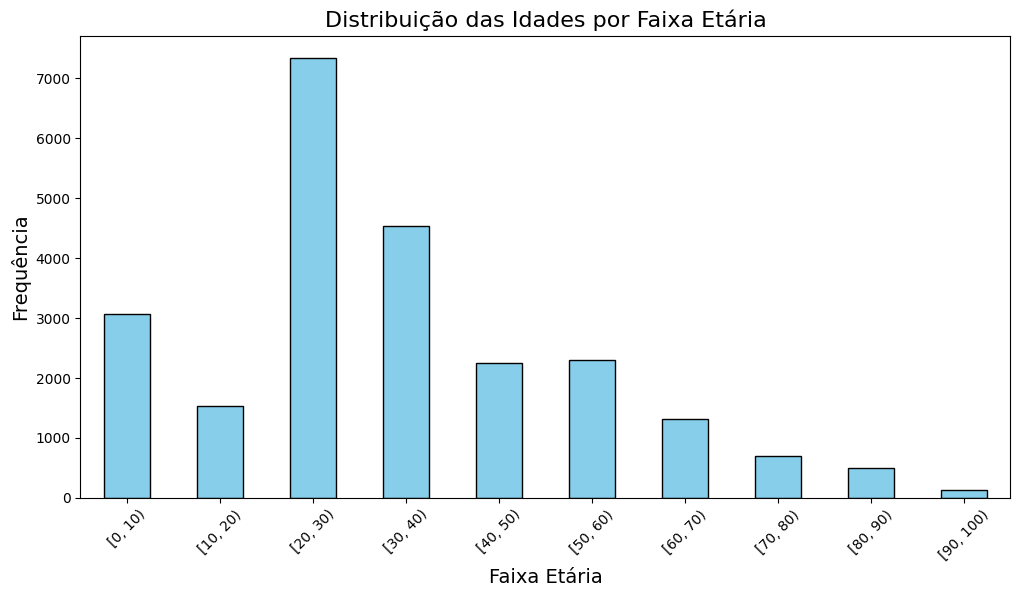

In [28]:
# Cria faixas etárias de 10 em 10 anos
df['faixa_etaria'] = pd.cut(df['age'], bins=range(0, 101, 10), right=False)

# Conta a frequência de cada faixa etária
contagem_faixas = df['faixa_etaria'].value_counts().sort_index()

# Plota o gráfico de barras
plt.figure(figsize=(12, 6))
contagem_faixas.plot(kind='bar', color='skyblue', edgecolor='black')

# Adiciona título e rótulos
plt.title('Distribuição das Idades por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização

# Exibe o gráfico
plt.show()

In [37]:
# Split the data to train, validation and split datasets 
X_train, X_test_val = train_test_split(df, test_size=0.2, random_state=7)

# Split test and val evenly
X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=7)


In [38]:
datagen_train = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.25],
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1/255.)

In [39]:
class CustomDataGenerator(Sequence):
    def __init__(self, generator, workers=1, use_multiprocessing=False, max_queue_size=10, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.workers = workers  # Armazena o valor de workers
        self.use_multiprocessing = use_multiprocessing  # Armazena o valor de use_multiprocessing
        self.max_queue_size = max_queue_size  # Armazena o valor de max_queue_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        return images, {'age_out': labels}

    def on_epoch_end(self):
        self.generator.on_epoch_end()

In [40]:
train_generator = CustomDataGenerator(
    datagen_train.flow_from_dataframe(
        dataframe=X_train,
        x_col='path',
        y_col='age',  # Alterado para única saída
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Modo para regressão única
    ),
    workers=4,
    use_multiprocessing=True,
    max_queue_size=20
)
val_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(
        dataframe=X_val,
        x_col='path',
        y_col='age',  # Alterado
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Alterado
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)

test_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(
        dataframe=X_test,
        x_col='path',
        y_col='age',  # Alterado
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Alterado
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)


Found 18940 validated image filenames.
Found 2368 validated image filenames.
Found 2368 validated image filenames.


In [41]:
if cnn_modelo == "InceptionV3":
    base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:136]:
        layer.trainable = False
    for layer in base.layers[136:]:
        layer.trainable = True

elif cnn_modelo == "MobileNetV2":
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:100]:
        layer.trainable = False
    for layer in base.layers[100:]:
        layer.trainable = True

elif cnn_modelo == "ResNet50":
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:150]:  # Ajustar o número de camadas a serem congeladas
        layer.trainable = False
    for layer in base.layers[150:]:
        layer.trainable = True

elif cnn_modelo == "EfficientNetB0":
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:200]:  # Ajustar conforme necessário
        layer.trainable = False
    for layer in base.layers[200:]:
        layer.trainable = True

elif cnn_modelo == "cnn_tcc_will":
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Primeira camada convolucional
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Segunda camada convolucional
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Terceira camada convolucional
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling e Camadas Fully Connected
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Camada de saída
    age_out = Dense(1, activation='linear', name='age_out')(x)

    # Criando o modelo final
    model = Model(inputs=inputs, outputs=age_out)
    model.summary()


else:
    print(f"Modelo {cnn_modelo} não suportado")
    raise ValueError(f"Modelo {cnn_modelo} não suportado") 

In [42]:
if cnn_modelo in ["InceptionV3", "MobileNetV2", "ResNet50", "EfficientNetB0", "cnn_tcc_will"]:

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Branch para idade apenas
    age = Dense(512, activation='relu')(x)
    age = Dropout(0.5)(age)
    age_out = Dense(1, activation='linear', name='age_out')(age)

    # Modelo com saída única
    model = Model(inputs=base.input, outputs=age_out)  # Saída única
    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 111, 111, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 109, 109, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 109, 109, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 54, 54, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 19,257,057 (73.46 MB)

 Non-trainable params: 3,595,328 (13.72 MB)

In [43]:
# Add callbacks and optimiser 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=5,          
    min_lr=0.00001,      
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    verbose=1,
    restore_best_weights=True
)
    
adam = Adam(learning_rate=0.001)

In [44]:
model.compile(
    optimizer=adam,
    loss={'age_out': tf.keras.losses.MeanSquaredError()},
    metrics={'age_out': tf.keras.metrics.MeanAbsoluteError()}
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 260s 662ms/step - loss: 201.9496 - mean_absolute_error: 9.9675 - val_loss: 90.4900 - val_mean_absolute_error: 7.4709 - learning_rate: 0.0010
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 170s 558ms/step - loss: 85.3557 - mean_absolute_error: 6.7296 - val_loss: 81.3653 - val_mean_absolute_error: 6.7699 - learning_rate: 0.0010
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 170s 560ms/step - loss: 69.4157 - mean_absolute_error: 6.0458 - val_loss: 64.9890 - val_mean_absolute_error: 6.1230 - learning_rate: 0.0010
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 169s 557ms/step - loss: 61.4111 - mean_absolute_error: 5.6884 - val_loss: 74.8321 - val_mean_absolute_error: 6.0865 - learning_rate: 0.0010
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 171s 563ms/step - loss: 60.2410 - mean_absolute_error: 5.5738 - val_loss: 73.0671 - val_mean_absolute_error: 5.8856 - learning_rate: 0.0010
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 168s 551ms/step - loss: 55.3874 - mean_absolute_error: 5.38

In [ ]:

# Salvar modelo nos dois formatos
model.save(f"ager_classifier_{cnn_modelo}.h5")
model.save(f"ager_classifier_{cnn_modelo}.keras")
print("Modelo salvo em HDF5 (.h5) e formato Keras (.keras)!")

df = pd.DataFrame(history.history)
nome_arquivo = f"history_{cnn_modelo}_humor.csv"
df.to_csv(nome_arquivo, index=False)
print(f"Histórico salvo em {nome_arquivo}")

Modelo salvo em HDF5 (.h5) e formato Keras (.keras)!


In [46]:
# Avaliar modelo no conjunto de teste
test_loss, test_mae = model.evaluate(test_generator)

# Calcular a média das idades no conjunto de teste
mean_age = np.mean(X_test['age'])

# Calcular a "acurácia relativa"
accuracy = 100 - ((test_mae / mean_age) * 100)

print(f"\nModelo: {cnn_modelo}")
print(f"Erro Médio Absoluto (MAE): {test_mae:.2f}")
print(f"Acurácia Estimada: {accuracy:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 47.7348 - mean_absolute_error: 4.9344

Modelo: InceptionV3
Erro Médio Absoluto (MAE): 4.96
Acurácia Estimada: 85.19%


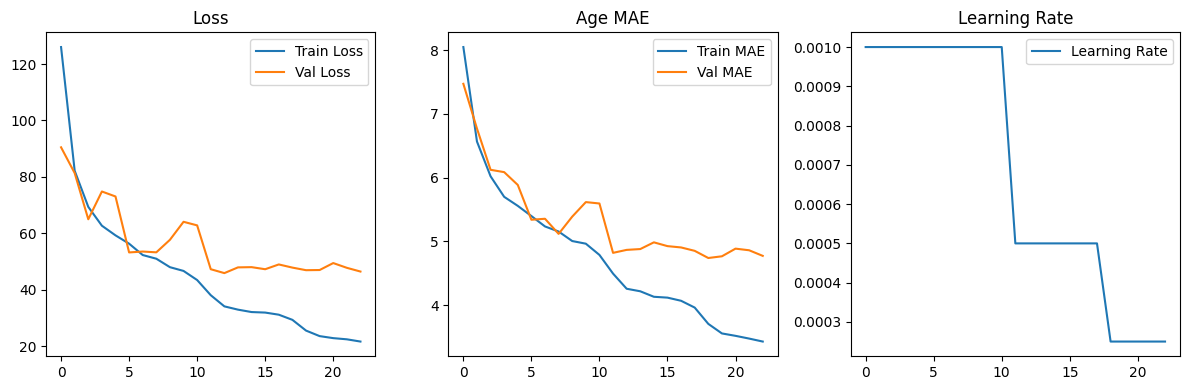

In [47]:
# Remover gráficos de gênero e ajustar layout
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# Age MAE (Corrigido para a chave correta)
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')  # Chave correta
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')  # Chave correta
plt.legend()
plt.title('Age MAE')

# Learning Rate
plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.legend()
plt.title('Learning Rate')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


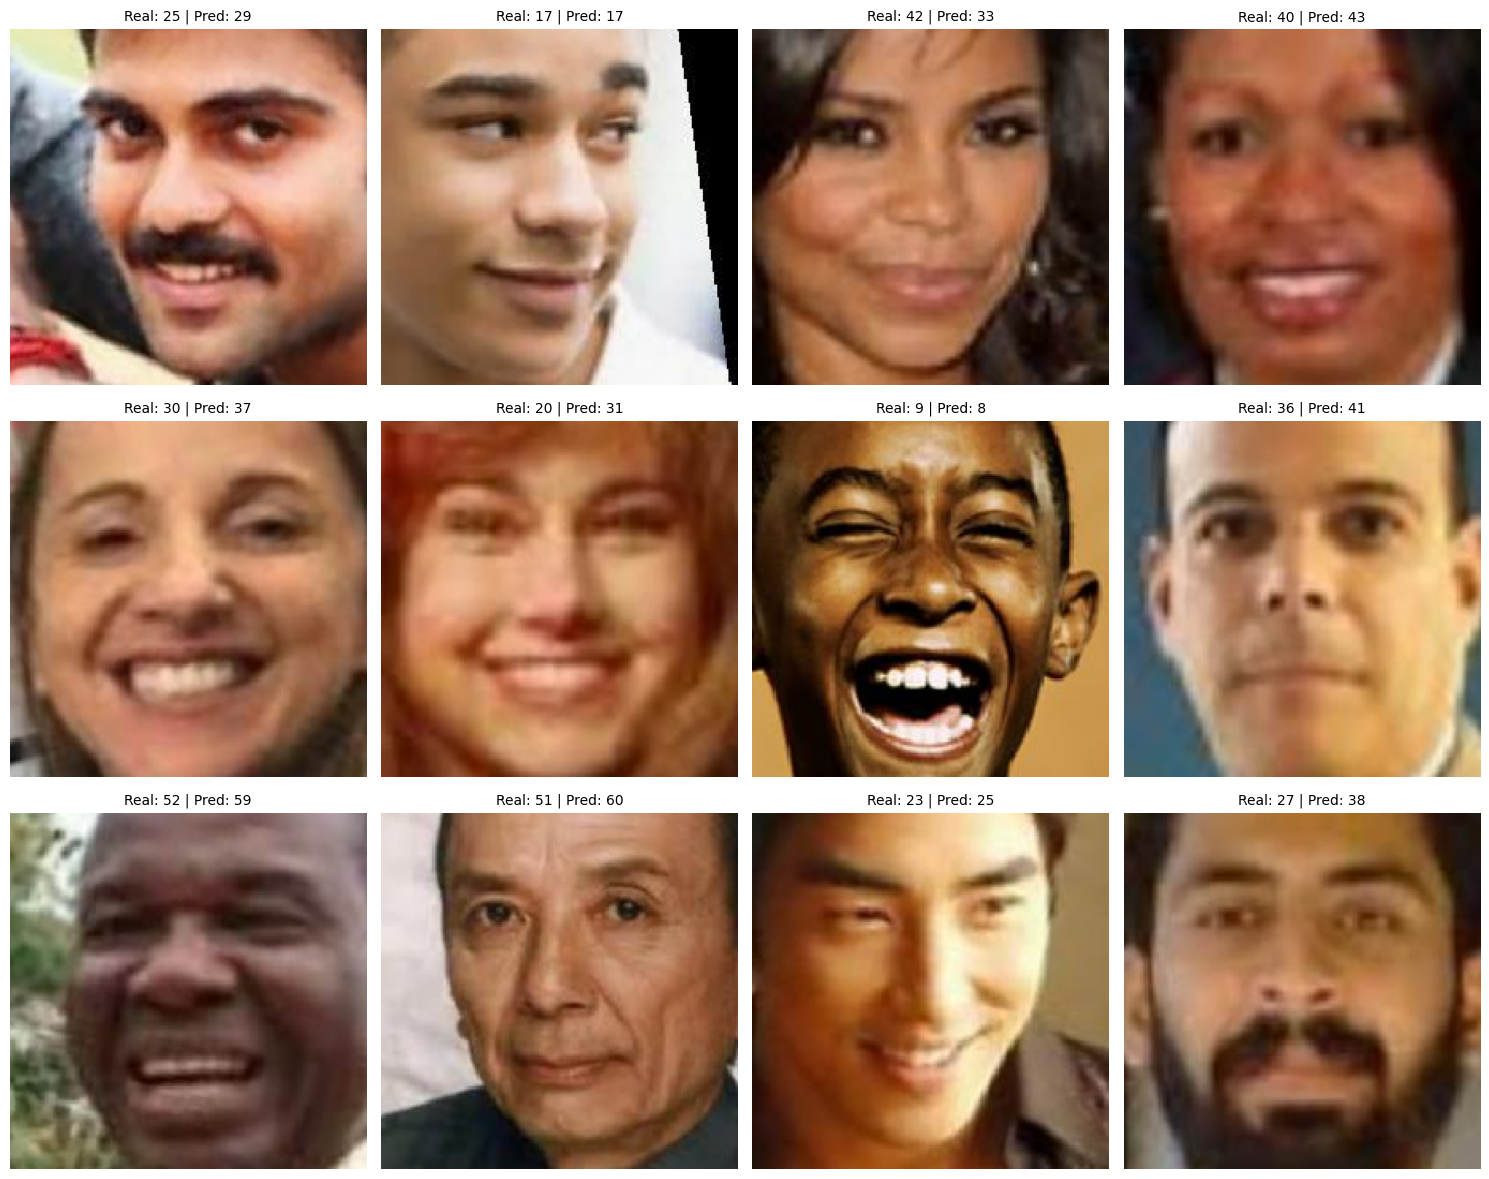

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Carregar o modelo salvo
model = load_model(f"/kaggle/working/ager_classifier_{cnn_modelo}.h5")

# Selecionar 12 imagens aleatórias do DataFrame original (data)
sample_data = df.sample(12)

plt.figure(figsize=(15, 12))

for i, row in enumerate(sample_data.itertuples()):  # Iterar pelas linhas do DataFrame
    img_path = row.path
    real_age = row.age  # Obter idade real do DataFrame

    # Carregar e pré-processar a imagem
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch

    # Fazer a previsão
    pred_age = model.predict(img_array)[0][0]  # Previsão da idade

    # Plotar a imagem
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Real: {real_age} | Pred: {int(round(pred_age))}", fontsize=10) # Mostra a idade real e a predita
    plt.axis('off')

plt.tight_layout()
plt.show()